In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

plt.style.use('ggplot')

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
dataset = load_dataset("app_reviews")
df = pd.DataFrame(dataset['train'])

Found cached dataset app_reviews (C:/Users/Splute/.cache/huggingface/datasets/app_reviews/default/0.0.0/20335b51b604b9bc04b7be253cd8445caa9ba93f15f39a4b0492b9e9102853de)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
# 按照"star"列进行分组
grouped = df.groupby('star')

# 初始化一个空的DataFrame，用于存放随机选择的样本
random_sample_df = pd.DataFrame()

# 遍历每个分组，从每个分组中随机选择100个样本，并添加到random_sample_df中
for group_name, group_data in grouped:
    if len(group_data) >= 100:
        random_sample = group_data.sample(100, random_state=66)  # 使用随机种子(random_state)确保结果可复现
    else:
        random_sample = group_data  # 如果某个类别样本数量小于100，则全部选择
    random_sample_df = random_sample_df.append(random_sample)

# 打印结果
print(random_sample_df['star'].value_counts())

5    100
4    100
3    100
2    100
1    100
Name: star, dtype: int64


In [4]:
df = random_sample_df
# 添加一个新的整数索引，并将其保存为'id'列
df['id'] = df.reset_index(drop=True).index
# 将'id'列移动到最左边
id_column = df['id']  # 获取'id'列
df.drop(columns=['id'], inplace=True)  # 删除'id'列
df.insert(0, 'id', id_column)  # 将'id'列插入到第一列

df

,id,package_name,review,date,star
246269,0,com.google.android.gms,Unnecessary update,March 21 2017,1
274412,1,com.google.android.gms,Why do. You force to use.this is 2 in1. With W...,April 28 2017,1
226081,2,com.google.android.gms,Lagg!! It crashes my YouTube I had to restart ...,February 24 2017,1
95157,3,com.dozuki.ifixit,Crap application,February 19 2016,1
237696,4,com.google.android.gms,Rubbish,March 12 2017,1
...,...,...,...,...,...
349,495,com.pilot51.voicenotify,DJCoulton Works great. Very nice indeed,May 26 2014,5
123031,496,com.frostwire.android,Lime line you have to has Frost wire love them...,December 06 2016,5
2289,497,org.openintents.filemanager,Awesome file manager This is a great file mana...,January 21 2014,5
214585,498,com.google.android.gms,Nice but irritating. Its a good app. But who t...,February 04 2017,5


## 1. VADER

In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm ## to add progress bars to loops and iterations

sia = SentimentIntensityAnalyzer()

In [6]:
# run on the entire dataset
vader_res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['review']
    myid = row['id']
    vader_res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

## 2. LSTM

In [7]:
from tensorflow.keras.models import load_model
clf_lstm = load_model('models/GloVe_LSTM')

In [8]:
# import word vectors

words = dict()
wird_filepath = 'embeddings\glove.twitter.27B\glove.twitter.27B.100d.txt'

def add_to_dict(d, filename):
    with open(filename, 'r') as f:
        for line in f.readlines():
            line = line.split(' ')

            try:
                d[line[0]] = np.array(line[1:],dtype=float)
            except:
                continue

add_to_dict(words, wird_filepath)

In [9]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Splute\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
# Use regular expressions to define word segmentation rules,
# and split text according to patterns that match regular expressions
tokenizer = nltk.RegexpTokenizer(r"\w+")

# find the root-word
lemmatizer = WordNetLemmatizer()

lemmatizer.lemmatize('feet')

# preprocess
def msg_to_token_list(string):
    tokens = tokenizer.tokenize(string)
    lowercased_tokens = [token.lower() for token in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in lowercased_tokens]
    useful_tokens = [token for token in lemmatized_tokens if token in words]

    return useful_tokens

In [11]:
# Use regular expressions to define word segmentation rules,
# and split text according to patterns that match regular expressions
tokenizer = nltk.RegexpTokenizer(r"\w+")

# find the root-word
lemmatizer = WordNetLemmatizer()

lemmatizer.lemmatize('feet')

# preprocess
def msg_to_token_list(string):
    tokens = tokenizer.tokenize(string)
    lowercased_tokens = [token.lower() for token in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in lowercased_tokens]
    useful_tokens = [token for token in lemmatized_tokens if token in words]

    return useful_tokens

In [16]:
def msg_to_word_vectors(msg, word_dict = words):
    processed_list_tokens = msg_to_token_list(msg)

    vectors = []

    for token in processed_list_tokens:
        if token not in word_dict:
            continue

        token_vector = word_dict[token]
        vectors.append(token_vector)

    return np.array(vectors, dtype=float)

In [17]:
# get x and y
def dff_to_X_y(dff):
    # y = dff['label'].to_numpy().astype(int)

    all_word_vector_sequences = []

    for msg in dff['review']:
        msg_as_vector_seq = msg_to_word_vectors(msg)

        if msg_as_vector_seq.shape[0] == 0:
            msg_as_vector_seq = np.zeros(shape=(1,100))

        all_word_vector_sequences.append(msg_as_vector_seq)

    # return all_word_vector_sequences, y
    return all_word_vector_sequences


In [18]:
from copy import deepcopy

def pad_X(X, desired_sequence_length = 38):
    X_copy = deepcopy(X) # create a totally new copy

    for i, x in enumerate(X):
        try:
            x_seq_len = x.shape[0]
            sequence_length_difference = desired_sequence_length - x_seq_len

            pad = np.zeros(shape=(sequence_length_difference, 100))

            X_copy[i] = np.concatenate([x,pad])
        except:
            X_copy[i] = x[:38]

    return np.array(X_copy).astype(float)

In [19]:
text_seq = dff_to_X_y(df)
text_seq_padded = pad_X(text_seq)

text_seq_padded.shape

(500, 38, 100)

In [20]:
predictions = clf_lstm.predict(text_seq_padded)
result_df = pd.DataFrame(predictions)
result_df = result_df.reset_index().rename(columns={'index':'id'})
# 使用字典指定要重命名的列
new_column_names = {0: 'H-LSTM_neg',
                    1: 'H-LSTM_neu',
                    2: 'H-LSTM_pos'}

# 使用rename()方法进行重命名
result_df.rename(columns=new_column_names, inplace=True)
result_df

,id,H-LSTM_neg,H-LSTM_neu,H-LSTM_pos
0,0,0.640827,0.340520,0.018653
1,1,0.201024,0.743915,0.055061
2,2,0.637013,0.254476,0.108512
3,3,0.507834,0.368515,0.123650
4,4,0.633552,0.307629,0.058819
...,...,...,...,...
495,495,0.000575,0.000909,0.998516
496,496,0.096333,0.545620,0.358047
497,497,0.103891,0.054368,0.841741
498,498,0.788313,0.101281,0.110407


In [21]:
vaders = pd.DataFrame(vader_res).T
vaders = vaders.reset_index().rename(columns={'index':'id'})

result_df = result_df.merge(df, how='left')
result_df = vaders.merge(result_df, how='left')

new_column_names = {'neg': 'vader_neg',
                    'neu': 'vader_neu',
                    'pos': 'vader_pos'}

result_df.rename(columns=new_column_names, inplace=True)

result_df.head()

,id,vader_neg,vader_neu,vader_pos,compound,H-LSTM_neg,H-LSTM_neu,H-LSTM_pos,package_name,review,date,star
0,0,0.000,1.000,0.0,0.0000,0.640827,0.340520,0.018653,com.google.android.gms,Unnecessary update,March 21 2017,1
1,1,0.000,1.000,0.0,0.0000,0.201024,0.743915,0.055061,com.google.android.gms,Why do. You force to use.this is 2 in1. With W...,April 28 2017,1
2,2,0.000,1.000,0.0,0.0000,0.637013,0.254476,0.108512,com.google.android.gms,Lagg!! It crashes my YouTube I had to restart ...,February 24 2017,1
3,3,0.722,0.278,0.0,-0.3818,0.507834,0.368515,0.123650,com.dozuki.ifixit,Crap application,February 19 2016,1
4,4,0.000,1.000,0.0,0.0000,0.633552,0.307629,0.058819,com.google.android.gms,Rubbish,March 12 2017,1


In [22]:
result_df.columns

Index(['id', 'vader_neg', 'vader_neu', 'vader_pos', 'compound', 'H-LSTM_neg',
       'H-LSTM_neu', 'H-LSTM_pos', 'package_name', 'review', 'date', 'star'],
      dtype='object')

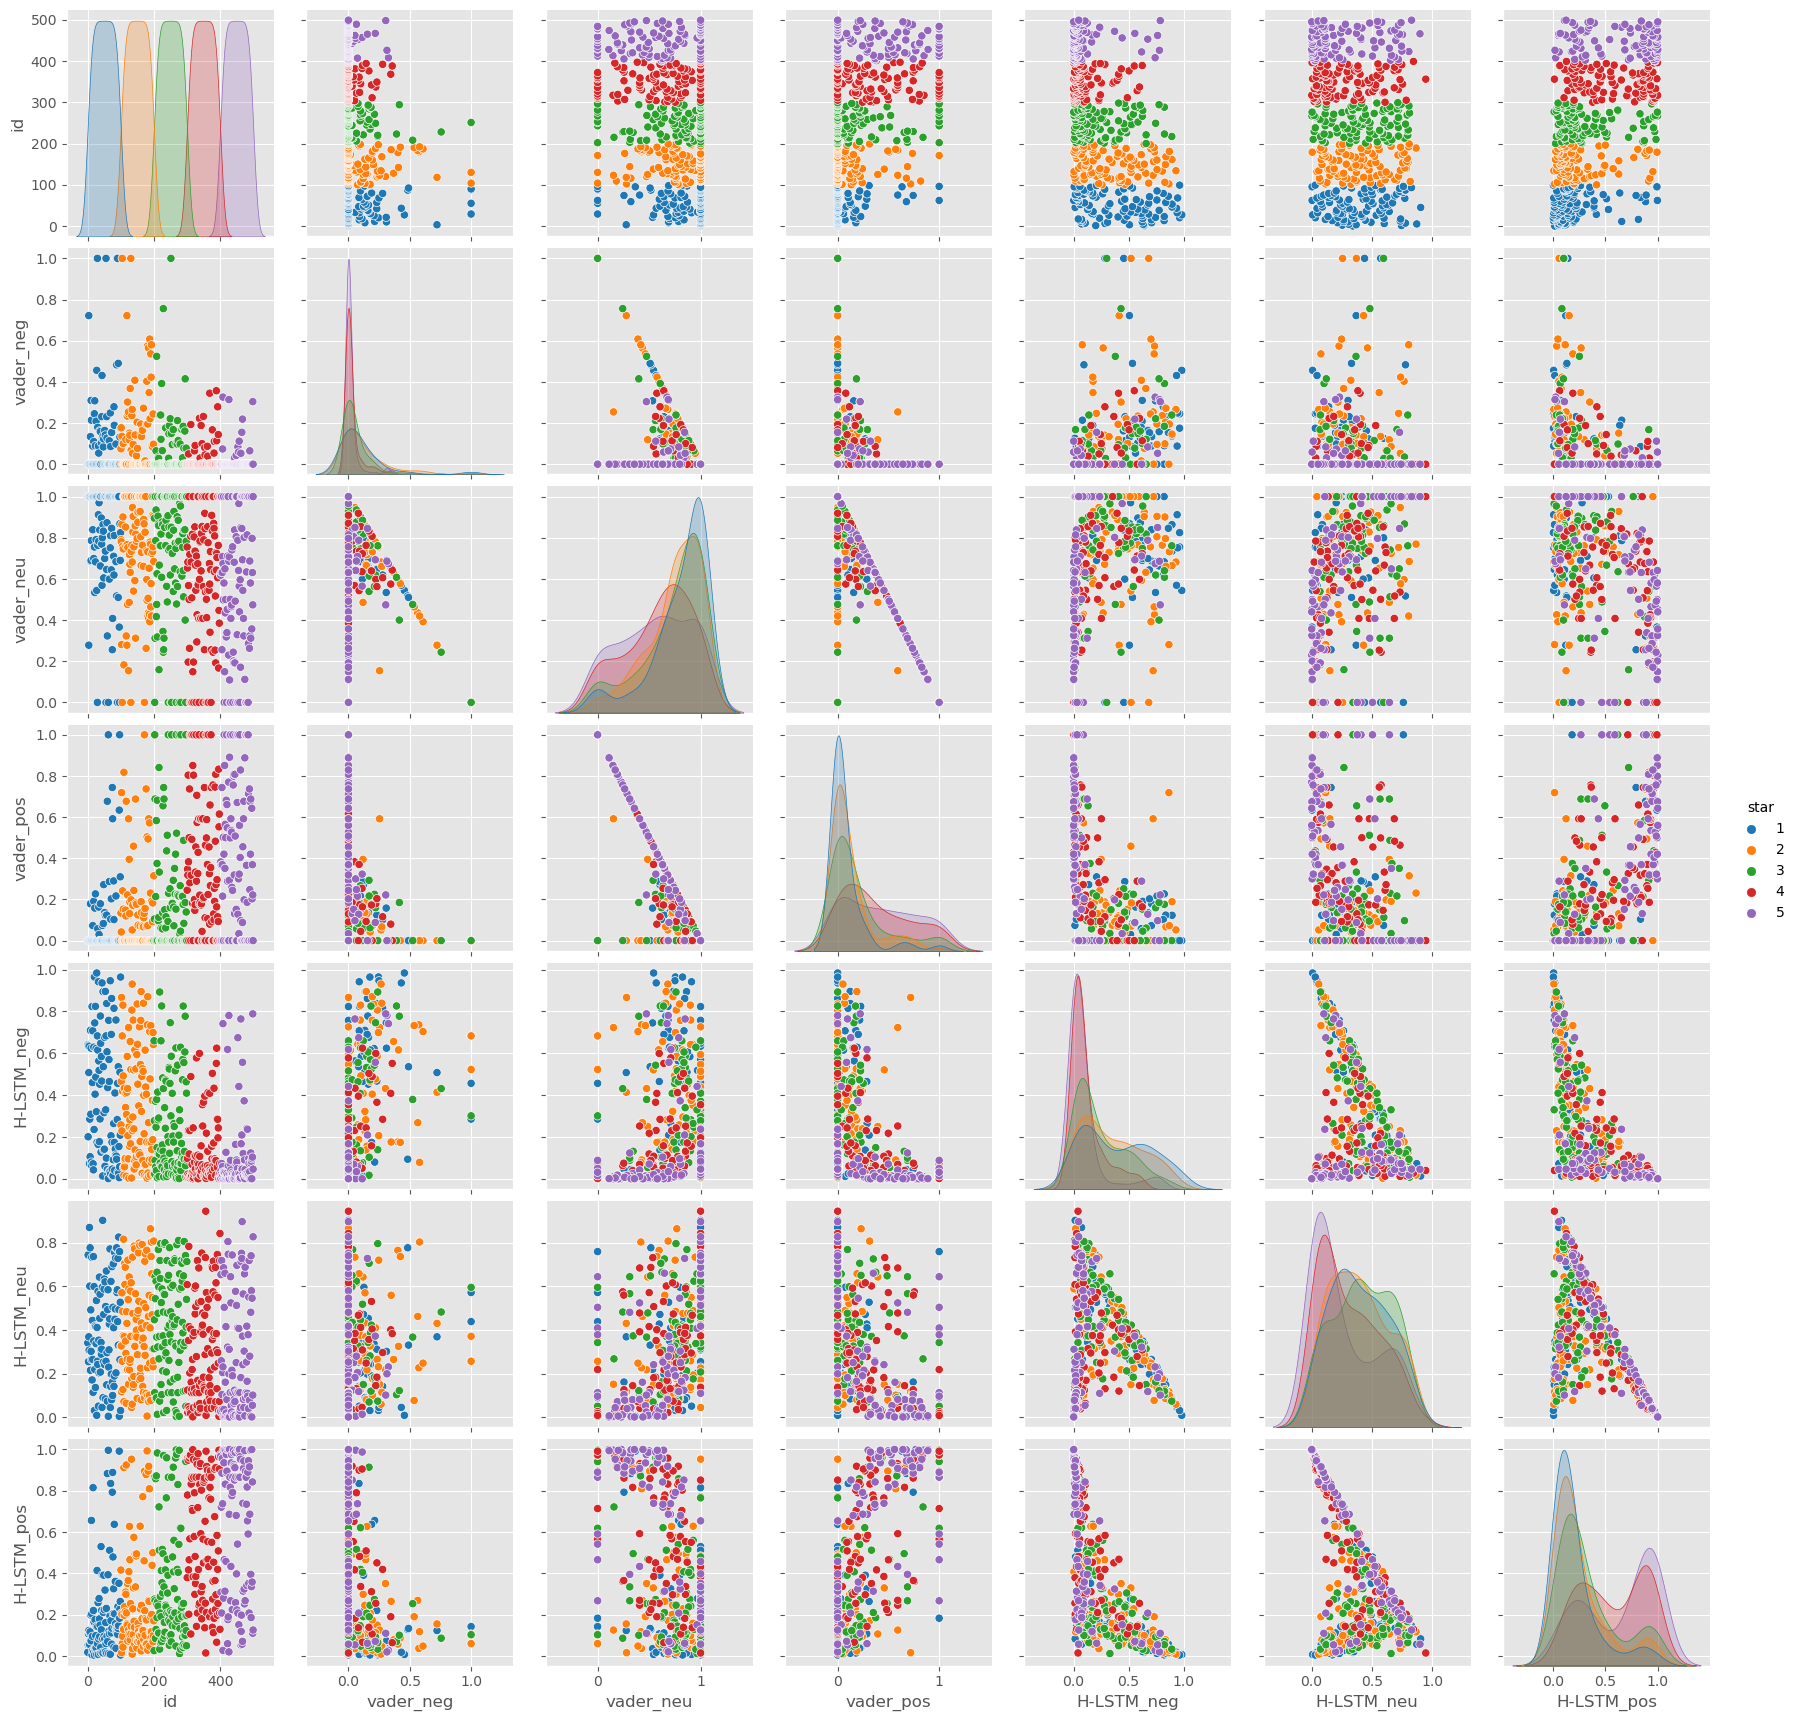

In [23]:
sns.pairplot(data = result_df, 
            vars=['id', 'vader_neg', 'vader_neu', 'vader_pos', 'H-LSTM_neg',
                'H-LSTM_neu', 'H-LSTM_pos'],
            hue = 'star',
            palette = 'tab10')

plt.show()

### Below is V1 =============================

In [34]:
texts = df['review_body'].tolist()

In [38]:
def clean_text(data):
    # 去除URL链接
    data = re.sub(r'http\S+', '', data)
    
    # 去除@提及的用户名
    data = re.sub(r'@\w+', '', data)
    
    # 去除#标签
    data = re.sub(r'#\w+', '', data)
    
    # 去除RT（转发）标识
    data = re.sub(r'RT\s+', '', data)
    
    # 去除多余的空格和换行符
    data = re.sub(r'\s+', ' ', data).strip()
    
    # tekenization using nltk / 分词
    data = word_tokenize(data)
    
    return data

In [39]:
texts = [' '.join(clean_text(text)) for text in texts]

In [40]:
# Tokenization + fitting using keras
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

In [41]:
def polarity_scores_lstm(example, tokenizer):
    cleaned_exa = clean_text(example)
    seq = tokenizer.texts_to_sequences(cleaned_exa)
    padded = pad_sequences(seq, maxlen=500)
    scores = clf_lstm.predict(padded)
    scores_dict = {
        'biLSTM_neg': scores[0][0],
        'biLSTM_neu': scores[0][1],
        'biLSTM_pos': scores[0][2]
    }

    return scores_dict

In [44]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['review_body']
    myid = row['id']
    vader_result = sia.polarity_scores(text)
    vader_result_rename = {}
    for key, value in vader_result.items():
        vader_result_rename[f"vader_{key}"] = value
    biLSTM_result = polarity_scores_lstm(example = text, tokenizer = tokenizer)
    both = {**vader_result_rename, **biLSTM_result}

    res[myid] = both



  0%|          | 0/500 [00:00<?, ?it/s]

In [45]:
result_df = pd.DataFrame(res).T
result_df = result_df.reset_index().rename(columns={'index':'id'})
result_df = result_df.merge(df, how='left')
result_df.head()

,id,vader_neg,vader_neu,vader_pos,vader_compound,biLSTM_neg,biLSTM_neu,biLSTM_pos,marketplace,customer_id,...,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,0,0.000,0.000,1.000,0.2960,0.212135,0.363094,0.424770,US,2975964,...,GoPro Rechargeable Battery 2.0 (HERO3/HERO3+ o...,Camera,5,0,0,0,1,Five Stars,ok,2015-08-31
1,1,0.000,0.389,0.611,0.7424,0.215961,0.360435,0.423604,US,23526356,...,Professional 58mm Center Pinch Lens Cap for CA...,Camera,5,0,0,0,1,Love it!!!,"Perfect, even sturdier than the original!",2015-08-31
2,2,0.027,0.908,0.065,0.8501,0.103040,0.552293,0.344667,US,52764145,...,Spy Tec Z12 Motion Activated Intelligent Secur...,Camera,2,1,1,0,1,Another Motion Detect Fail,"If the words, &#34;Cheap Chinese Junk&#34; com...",2015-08-31
3,3,0.053,0.798,0.149,0.8033,0.168093,0.538959,0.292948,US,47348933,...,"Celestron UpClose G2 10x25 Monocular, Black (7...",Camera,5,0,0,0,1,Exactly what I wanted and expected.,Exactly what I wanted and expected. Perfect fo...,2015-08-31
4,4,0.025,0.739,0.237,0.9298,0.235096,0.514151,0.250754,US,33680700,...,Vidpro XM-L Wired Lavalier microphone - 20' Au...,Camera,5,1,1,0,1,Good mic at a Good Price...Not Canon Though.,I will look past the fact that they tricked me...,2015-08-31


## Compared these two models

In [46]:

result_df.columns

Index(['id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'biLSTM_neg', 'biLSTM_neu', 'biLSTM_pos', 'marketplace', 'customer_id',
       'review_id', 'product_id', 'product_parent', 'product_title',
       'product_category', 'star_rating', 'helpful_votes', 'total_votes',
       'vine', 'verified_purchase', 'review_headline', 'review_body',
       'review_date'],
      dtype='object')

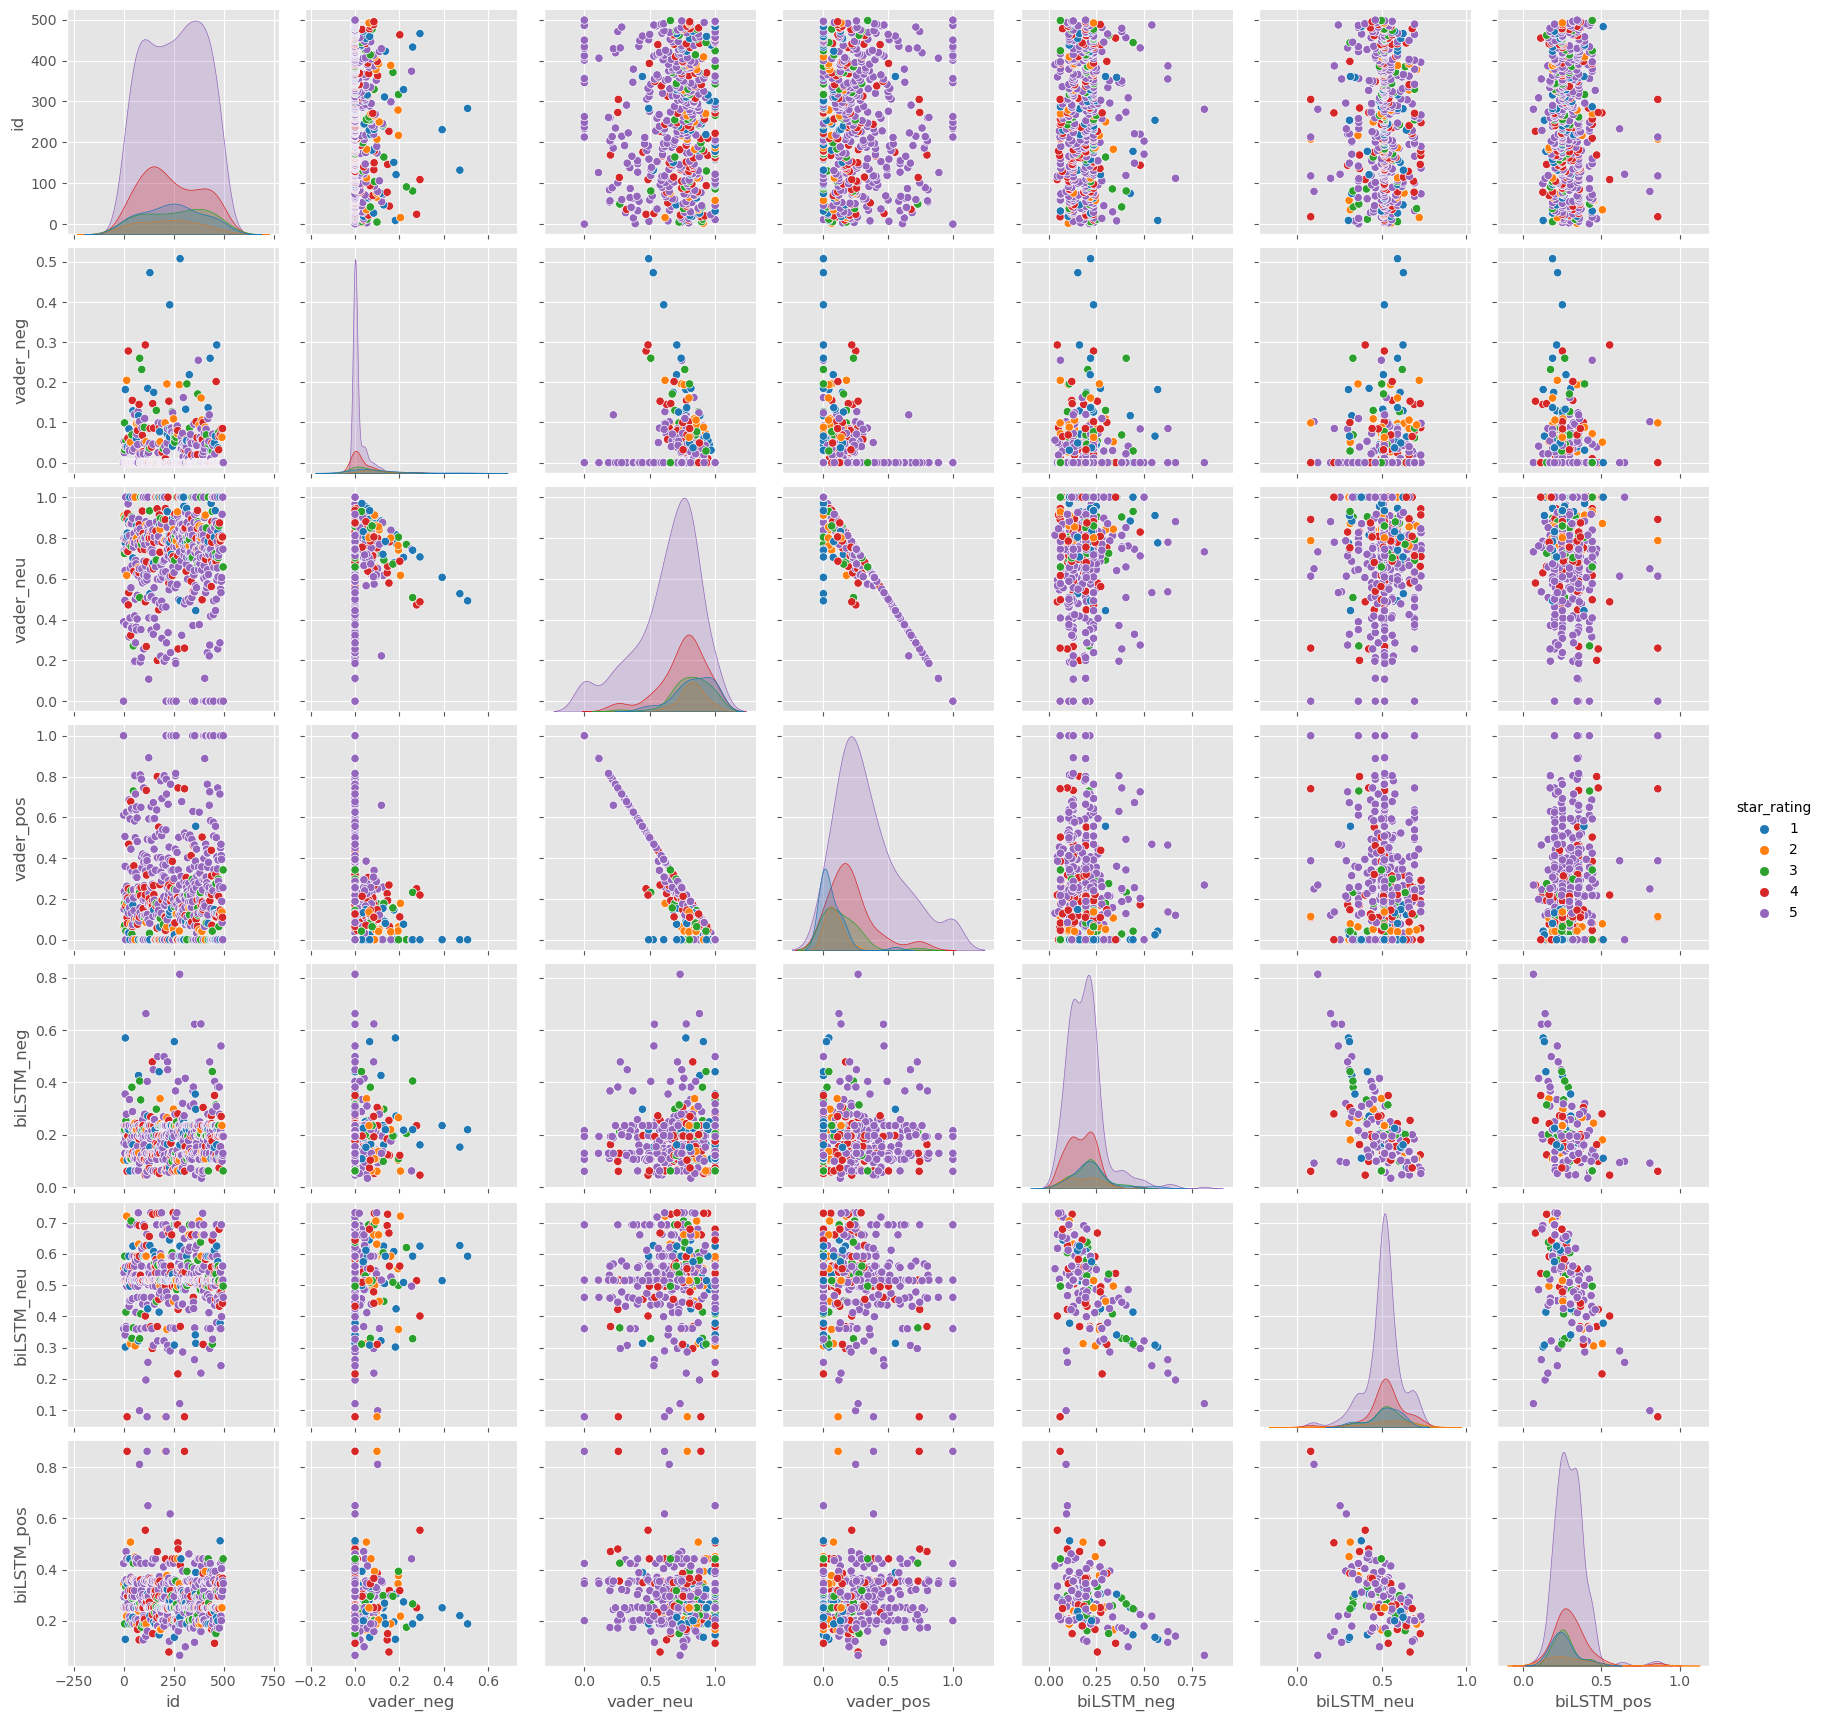

In [48]:
sns.pairplot(data = result_df, 
            vars=['id', 'vader_neg', 'vader_neu', 'vader_pos',
                    'biLSTM_neg', 'biLSTM_neu', 'biLSTM_pos'],
            hue = 'star_rating',
            palette = 'tab10')

plt.show()